### Imports

In [1]:
import gc

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler
from torch import nn

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import seaborn as sns

RANDOM_SEED=30
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if(torch.cuda.is_available()):
    torch.cuda.empty_cache()
    gc.collect()


### Hyperparameters

In [2]:
BATCH_SIZE = 8
MAX_LEN=256
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

### There are multiple ways to obtain datasets: with/without stopwords, augmented with hateEval/not augmented, and with 0 label samples oversampled

In [3]:
def create_dataframes(stopwords=False, oversampling=0, augmented=False):
    if(stopwords and augmented):
        df_train=pd.read_csv('train_augmented_with_stopwords.csv')
        df_val=pd.read_csv('val_with_stopwords.csv')
    elif(stopwords and (not augmented)):
        df_train=pd.read_csv('train_new_with_stopwords.csv')
        df_val=pd.read_csv('val_with_stopwords.csv')
        
    elif((not stopwords) and augmented):
        df_train=pd.read_csv('train_augmented_without_stopwords.csv')
        df_val=pd.read_csv('val_without_stopwords.csv')
    
    elif((not stopwords) and (not augmented)):
        df_train=pd.read_csv('train_new_without_stopwords.csv')
        df_val=pd.read_csv('val_without_stopwords.csv')
        
    df_train_0=df_train.loc[df_train['label']==0]
    for i in range(oversampling):
        df_train=df_train.append(df_train_0, ignore_index=True)
        
    return df_train, df_val


df_train, df_val=create_dataframes(augmented=True)
print(df_train.shape)
print(df_val.shape)

(35089, 3)
(3966, 3)


### Creating Dataset and Model

In [4]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, output_hidden_states=True)

class TweetDataset(Dataset):

    def __init__(self, tweets, labels, tokenizer, max_len, transform = None):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = transform
  
    def __len__(self):
        return len(self.tweets)
  
    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation = True,
        )
        sample = {
        'text': tweet,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'label': torch.tensor(label, dtype=torch.long)
        }
        if(self.transform):
            sample = self.transform(sample)
        return sample
        
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetDataset(
    tweets=df['tweet'].to_numpy(),
    labels=df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
    )

    return DataLoader(
    ds,
    batch_size=batch_size,
    sampler=RandomSampler(ds),
    num_workers=8
    )
    

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)


# only for kaggle submission
# class TestDataset(Dataset):

#     def __init__(self, tweets, index, tokenizer, max_len, transform = None):
#         self.tweets = tweets
#         self.index = index
#         self.tokenizer = tokenizer
#         self.max_len = max_len
#         self.transform = transform
  
#     def __len__(self):
#         return len(self.tweets)
  
#     def __getitem__(self, item):
#         tweet = str(self.tweets[item])
#         index = self.index[item]
#         encoding = self.tokenizer.encode_plus(
#         tweet,
#         add_special_tokens=True,
#         max_length=self.max_len,
#         return_token_type_ids=False,
#         padding='max_length',
#         return_attention_mask=True,
#         return_tensors='pt',
#         truncation = True,
#         )
#         sample = {
#         'text': tweet,
#         'input_ids': encoding['input_ids'].flatten(),
#         'attention_mask': encoding['attention_mask'].flatten(),
#         'index': index
#         }
#         if(self.transform):
#             sample = self.transform(sample)
#         return sample

# def create_test_loader(df, tokenizer, max_len, batch_size):
#     ds = TestDataset(
#     tweets=df['tweet'].to_numpy(),
#     index=df['index'].to_numpy(),
#     tokenizer=tokenizer,
#     max_len=max_len
#     )

#     return DataLoader(
#     ds,
#     batch_size=batch_size,
#     num_workers=8
#     )
    
# test_data_loader = create_test_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
class HateSpeechClassifier(nn.Module):

    def __init__(self, n_classes, lm):
        super(HateSpeechClassifier, self).__init__()
        self.lm = lm
        self.drop = nn.Dropout(p=0.2)
        self.out = nn.Sequential(
            # nn.Linear(self.lm.config.hidden_size, 512),
            # nn.Tanh(),
            nn.Linear(self.lm.config.hidden_size, 256), 
            nn.ReLU(), 
            nn.Linear(256, 32), 
            nn.Tanh(),
            nn.Linear(32, n_classes),
            # nn.Softmax(n_classes),
        )
  
    def forward(self, input_ids, attention_mask):
        bert_output = self.lm(
        input_ids=input_ids,
        attention_mask=attention_mask
        )
        output = self.drop(bert_output[1])
        return self.out(output)

In [6]:
model = HateSpeechClassifier(n_classes=3, lm = bert_model)
model = model.to(device)

### Training

In [7]:
def train_epoch(
    model,
    data_loader, 
    loss_func, 
    optimizer, 
    device, 
    scheduler,
    n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['label'].to(device)
        
        output = model(
            input_ids = input_ids,
            attention_mask = attention_mask
        )
        
        _, prediction = torch.max(output, dim=1)
        loss = loss_func(output, labels)
        
        correct_predictions += torch.sum(prediction == labels)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double() / n_examples, np.mean(losses)


def val_epoch(
    model,
    data_loader, 
    device,
):
    p=[]
    y_true=[]
    model.eval()
    with torch.no_grad():
        for d in data_loader:
            output = model(
                input_ids=d['input_ids'].to(device),
                attention_mask=d['attention_mask'].to(device),
            )
            y_true+=(d['label'].tolist())
            _, prediction=torch.max(output, dim=1)
            p+=prediction.tolist()
        
        
    prediction=np.array(p)
    y_true=np.array(y_true)
    
    accuracy=accuracy_score(y_true, prediction)
    macro_f1_score=f1_score(y_true, prediction, average='macro')
    conf_mat=confusion_matrix(y_true, prediction)
    
    return accuracy, macro_f1_score, conf_mat


In [8]:
EPOCHS = 5

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-9)
total_steps = len(train_data_loader)*EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, 
    num_training_steps=total_steps
)

loss_func = nn.CrossEntropyLoss().to(device)

In [9]:
best_epoch=0
best_score=0
for i in range(EPOCHS):
    train_accuracy, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_func,
        optimizer,
        device,
        scheduler, 
        len(df_train)
    )
    print("Epoch: ", i)
    # print("Accuracy: "+ str(train_accuracy.item()) + "\tLoss: "+str(train_loss))
    
    val_accuracy, val_f1_score, conf_mat=val_epoch(model=model, data_loader=val_data_loader, device=device)
    print("Val accuracy: "+str(val_accuracy)+"\tVal f1_score: "+str(val_f1_score))
    if(val_f1_score>best_score):
        best_epoch=i
        best_score=val_f1_score
        best_conf_mat=conf_mat
        best_accuracy=val_accuracy
        torch.save(model.state_dict(), './bert-fnn-oversampled1-1.pt')
    
print("Ideal number of epochs: ", best_epoch+1)
best_epoch+=1


KeyboardInterrupt: 

In [27]:
torch.cuda.empty_cache()
gc.collect()

7037

Epoch:  3
Accuracy:  0.9041855774079677
F1-score:  0.7546080617778644
Confusion matrix
 [[  98  130   24]
 [  71 2914   95]
 [  10   50  574]]


<AxesSubplot:>

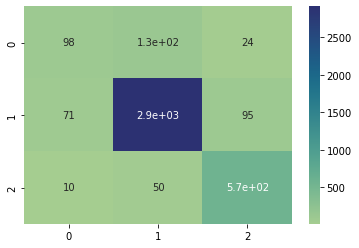

In [61]:
print("Epoch: ", best_epoch)
print("Accuracy: ", best_accuracy)
print('F1-score: ', best_score)
print("Confusion matrix\n", best_conf_mat)
sns.heatmap(best_conf_mat, annot=True, cmap='crest')